In [12]:
import ipaddress
import pandas as pd
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score, GridSearchCV
%matplotlib inline


def convert_ip2int(ip_add):
    '''
    converts ip address to equivalent integer value
    '''
    # ip = ipaddress.ip_address(ip_add)
    # ip_ver = 4 if '.' in ip_add else 6
    try:
        if '.' in str(ip_add):  # ipv4
            ip = ipaddress.IPv4Address(ip_add)
        elif ':' in str(ip_add):  # ipv6
            ip = ipaddress.IPv6Address(ip_add)
        else:
            print('Invalid IP version', ip_add)
            ip = 0  # 0 refers invalid ip address
    except Exception as e:
        print('Invalid IP address: ', e)
        ip = 0  # 0 refers invalid ip address
    return int(ip)


def normalize_data(df_exp):
    '''
    Normalize data using MinMaxScaler
    '''
    # Normalize data: Method 1 
    df_hist = df_exp.astype(float)
    x = df_hist.values #returns a numpy array
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    df_scaled = pd.DataFrame(x_scaled)
    df_scaled.columns = df_hist.columns

    # # Normalize data: Method 2
    # df_hist = df_hist.astype(float)
    # df_scaled = df_hist.apply(preprocessing.normalize)
    # # df_scaled = (df_hist-df_hist.mean())/df_hist.std()
    return df_scaled


# remove the unique columns from the dataframe because they will not contribute for the machine learning model
def filter_columns(df):
    '''
    returns the list of all unique values and single value columns in the dataframe
    '''
    cols_delete = []
    for col in df.columns:
        n_unique = df[col].nunique()
        if n_unique == 1 or n_unique == len(df):
            cols_delete.append(col)
    print('Columns to remove from the dataset:', cols_delete)
    return cols_delete

In [5]:
df_master = pd.read_csv('../data/processed/iot_23_small_4_10000000.csv')
df_master = df_master.rename(columns={'detailed-label': 'multi_label'})

/Users/guru/miniconda/envs/sec-iot/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3012: DtypeWarning: Columns (9,10) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [6]:
df_encoded = df_master.copy()
df_encoded = df_encoded.drop(filter_columns(df_encoded), axis=1)

Columns to remove from the dataset: ['ts', 'uid', 'local_orig', 'local_resp', 'tunnel_parents']


In [7]:
df_encoded['service'] = df_encoded['service'].astype(str).str.replace('-','unknown')
df_encoded = pd.get_dummies(data=df_encoded, columns=['proto', 'service', 'conn_state', 'history']) # encode categorical variables
df_encoded.columns

Index(['id_orig_h', 'id_orig_p', 'id_resp_h', 'id_resp_p', 'duration',
       'orig_bytes', 'resp_bytes', 'missed_bytes', 'orig_pkts',
       'orig_ip_bytes',
       ...
       'history_ShArr', 'history_ShDadAttt', 'history_ShR', 'history_ShwA',
       'history_ShwAr', 'history_ShwR', 'history_Sr', 'history_^d',
       'history_^f', 'history_^hR'],
      dtype='object', length=129)

In [ ]:
# Replacing '-' with 0
# Need to check if this is the best way to do this
df_encoded['id_orig_h'] = df_encoded['id_orig_h'].str.replace('_', '.')
df_encoded['id_resp_h'] = df_encoded['id_resp_h'].str.replace('_', '.')
df_encoded['multi_label'] = np.where((df_encoded['multi_label']=='-'), 'benign', df_encoded['multi_label'])
df_encoded['duration'] = df_encoded['duration'].str.replace('-','0').str.replace('_', '.0')
df_encoded['orig_bytes'] = df_encoded['orig_bytes'].astype(str).str.replace('-','0', regex=True)
df_encoded['resp_bytes'] = df_encoded['resp_bytes'].astype(str).str.replace('-','0')
df_encoded['label'] = df_encoded['label'].str.lower().str.replace('malicious', '1').str.replace('benign', '0').astype(int)


In [13]:
df_encoded['id_orig_h'] = df_encoded.id_orig_h.apply(convert_ip2int)
df_encoded['id_resp_h'] = df_encoded.id_resp_h.apply(convert_ip2int)

df_labels = df_encoded[['label', 'multi_label']]
df_encoded = normalize_data(df_encoded.drop(['label', 'multi_label'], axis=1))

df_encoded['label'] = df_labels['label']
df_encoded['multi_label'] = df_labels['multi_label']

# df_encoded.to_csv('../data/processed/iot_23_small_4_10000000_encoded.csv', index=False)

Invalid IP version 3232235976
Invalid IP version 3232235976
Invalid IP version 3232235976
Invalid IP version 3232235976
Invalid IP version 3232235976
Invalid IP version 3232235976
Invalid IP version 3232235976
Invalid IP version 3232235976
Invalid IP version 3232235976
Invalid IP version 3232235976
Invalid IP version 3232235976
Invalid IP version 3232235976
Invalid IP version 3232235976
Invalid IP version 3232235976
Invalid IP version 3232235976
Invalid IP version 3232235976
Invalid IP version 3232235976
Invalid IP version 3232235976
Invalid IP version 3232235976
Invalid IP version 3232235976
Invalid IP version 3232235976
Invalid IP version 3232235976
Invalid IP version 3232235976
Invalid IP version 3232235976
Invalid IP version 3232235976
Invalid IP version 3232235976
Invalid IP version 3232235976
Invalid IP version 3232235976
Invalid IP version 3232235976
Invalid IP version 3232235976
Invalid IP version 3232235976
Invalid IP version 3232235976
Invalid IP version 3232235976
Invalid IP

KeyboardInterrupt: 

In [ ]:
df_encoded = 

In [ ]:
def train_model(data, model_name, clf_type):
    '''
    Train and test the model using the training data
    '''
    X = data.drop(['label', 'multi_label'], axis=1)
    X = normalize_data(X)
    
    if clf_type=='binary':
        y = data['label']
        
    elif clf_type=='multiclass':
        y = data['multi_label']
        # Transforming non numerical labels into numerical labels
        encoder = preprocessing.LabelEncoder()
        # encoding train labels
        y = encoder.fit_transform(y)

    # 80% training and 20% test, random_state=11 for reproducibility
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state=11) 

    if model_name.lower() == 'svm' or model_name.lower() == 'svc':
        # SVM classifier 1
        train_model = SVC(kernel='linear', verbose=False)
        # Performing CV to tune parameters for best SVM fit 
        # Create the parameter grid based on the results of random search 
        # params_grid = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
        #                     'C': [1, 10, 100, 1000]},
        #                     {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]
        # svm_model = GridSearchCV(SVC(), params_grid, cv=5)
    
    elif model_name.lower() == 'rf' or model_name.lower() == 'randomforest':
        train_model = RandomForestClassifier()
        
    elif model_name.lower() == 'dt' or model_name.lower() == 'decisiontree':
        train_model = DecisionTreeClassifier()
        
    elif model_name.lower() == 'gb' or model_name.lower() == 'gradientboosting':
        train_model = GradientBoostingClassifier()
    
    train_model.fit(X_train, y_train)
    y_pred = train_model.predict(X_test)
    
    y_pred_label = list(encoder.inverse_transform(y_pred))
    y_test_label = list(encoder.inverse_transform(y_test))
    
    # # SVM classifier 2
    # SVM_classifier = SVC(C=1.0, cache_size=1500, verbose=True).fit(X_train, y_train)
    # print(SVM_classifier.score(X_test, y_test))
    # y_pred = SVM_classifier.predict(X_test)

    clf_matrix = confusion_matrix(y_test_label, y_pred_label)
    clf_report = classification_report(y_test_label, y_pred_label, zero_division=0) # output_dict=True
    return clf_matrix, clf_report


clf_type = 'multiclass' # 'binary' or 'multiclass'
model_name = 'dt' # 'SVM' or 'RandomForest'= 'rf'

clf_matrix, clf_report  = train_model(df_encoded, model_name, clf_type)
print(clf_matrix)
print(clf_report)


KeyboardInterrupt: 

In [ ]:
def show_features(df):
    '''
    shows the features of the dataset
    '''
    for col in df.columns:
        data_type = df[col].dtype
        val_counts = df[col].value_counts()
        len_values = len(val_counts)
        # print(f'{len_values}')
        # if (len_values < 100) and data_type == 'object':
        if data_type == 'object':
            val_counts = df[col].value_counts()
            len_values = len(val_counts)
            print(f'{col} ({data_type})\t len(value_counts): {len_values}')
            # val_counts.plot(kind='bar', title=col, figsize=(10, 5), legend=False)
            # plt.barh(val_counts.index, val_counts)
            # plt.show()
        else:
            print(f'    {col} ({data_type}) \t len(value_counts): {len_values}')
            # val_counts.plot(kind='bar', title=col, figsize=(10, 5), legend=False)
            # plt.hist(df[col], bins=1, color='blue', alpha=0.5, rwidth=0.8)
            # plt.show()

# Feature Selection:

array([<AxesSubplot:ylabel='multi_label'>], dtype=object)

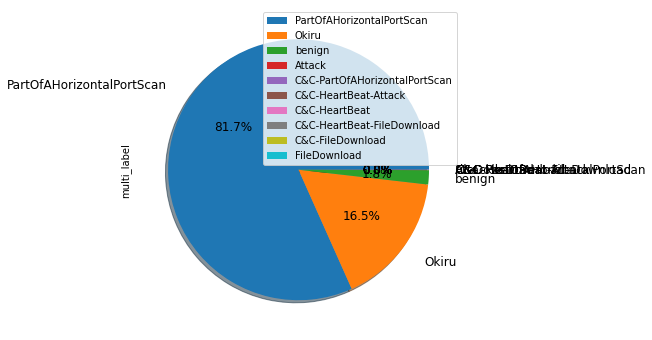

In [ ]:
df_encoded.multi_label.value_counts().plot.pie(subplots=True, shadow=True, autopct='%1.1f%%', figsize=(6, 6), labeldistance=1.2, legend=True, fontsize=12)

In [ ]:
df_features = df_encoded.drop(['label', 'multi_label'], axis=1)
df_features.head(5)

,id_orig_h,id_orig_p,id_resp_h,id_resp_p,duration,orig_bytes,resp_bytes,orig_pkts,orig_ip_bytes,resp_pkts,...,conn_state_SF,history_-,history_Dd,history_S,history_ShADadfF,history_ShADadttfF,history_ShAdDaR,history_ShAdDafr,history_ShAr,history_Sr
0,3232235976,52724,2808329966,80,1.0978591,149,119442,174,11698,172,...,1,0,0,0,0,1,0,0,0,0
1,3232235976,52726,2808329966,80,2.0182247,149,119442,172,11570,170,...,1,0,0,0,0,1,0,0,0,0
2,3232235976,52728,2808329966,80,1.0675550,152,83118,124,8120,122,...,1,0,0,0,0,1,0,0,0,0
3,3232235976,52730,2808329966,80,1.0798966,149,88797,136,8578,134,...,1,0,0,0,0,1,0,0,0,0
4,3232235976,52732,2808329966,80,1.0938142,149,117700,170,11602,170,...,1,0,0,0,0,1,0,0,0,0


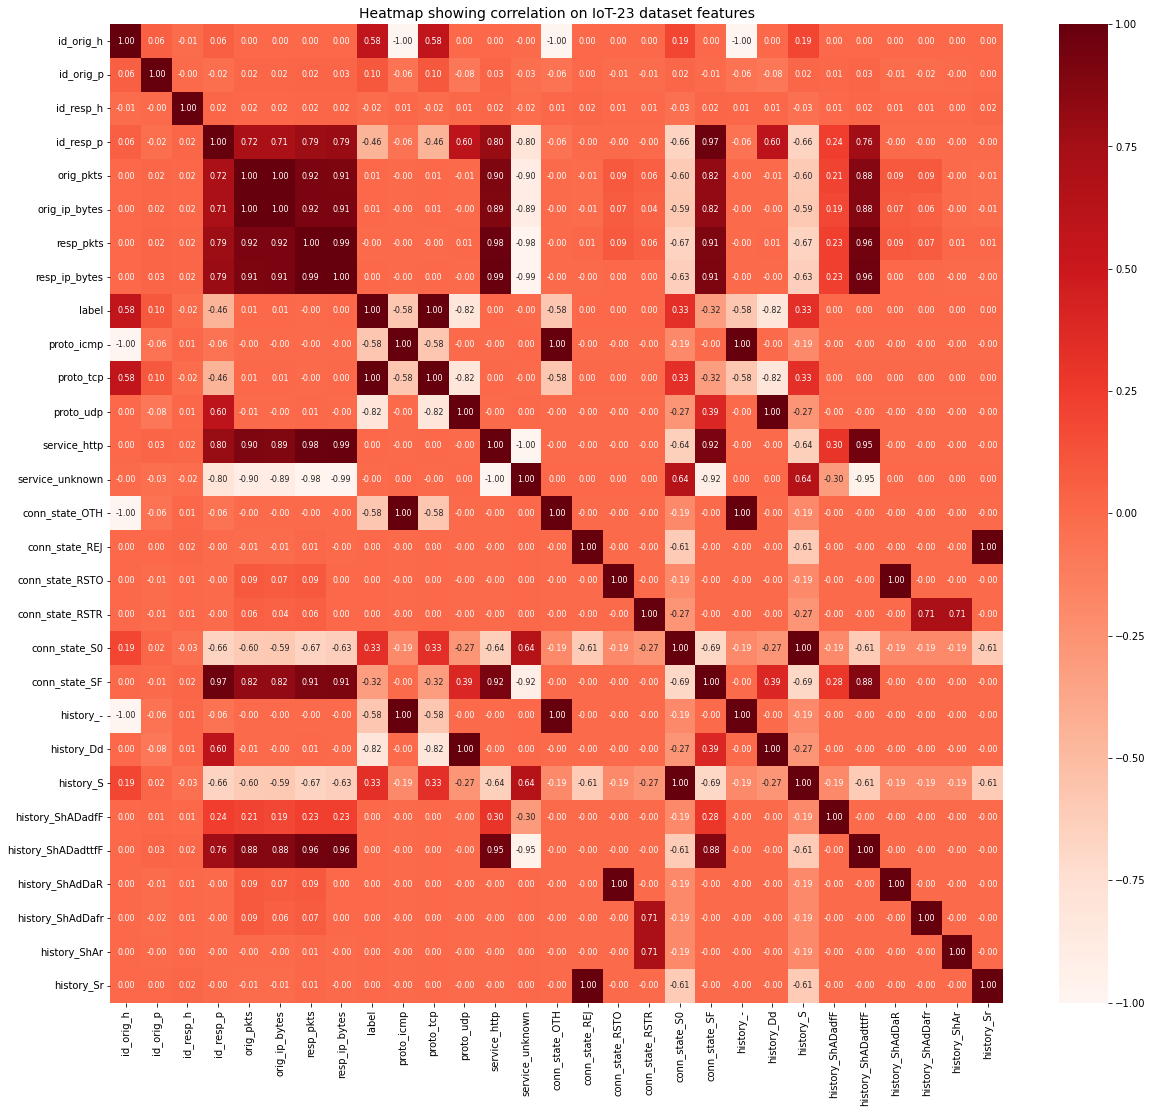

In [ ]:
#Using Pearson Correlation
plt.figure(figsize=(20,18))
cor = df_encoded.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds, fmt='.2f', annot_kws={'size': 8})
plt.title('Heatmap showing correlation on IoT-23 dataset features', fontsize=14)
plt.show()